In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys

In [3]:
import riskfolio as rp

In [4]:
df_train, df_test = pd.read_pickle(r'D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\data_mestrado.pkl')

In [5]:
df_test.isnull().mean()

asset_identifier    0.000000
ric                 0.000000
date                0.000000
close               0.000000
universe            0.000000
ret                 0.000000
vol                 0.000000
yhat                0.403580
target              0.403580
ibov_close          0.000000
ibov_ret            0.000000
ibov_vol            0.000000
ibov_correlation    0.000000
ibov_beta           0.000000
calibrated_yhat     0.000008
dtype: float64

In [6]:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

In [7]:
%%time
list_df_weights = []
for date, data in df_test.groupby('date'):
    data = data.query("universe")
    #Get mu
    mu = data.pivot(columns = 'asset_identifier', index = 'date', values = 'calibrated_yhat')
    # mu = data.pivot(columns = 'asset_identifier', index = 'date', values = 'target')
    # mu[mu<0]=0
    #Approximate the correlation matrix
    diretional_risk = data.eval('cov = ibov_beta * ibov_vol').pivot(columns = 'asset_identifier', index = 'date', values = 'calibrated_yhat')
    S = diretional_risk.T @ diretional_risk
    for asset in S.index:
        S[asset][asset] = data.query("asset_identifier == @asset")['vol']**2
    #Optimize portfolio
    Y = data.pivot(columns='asset_identifier', index = 'date', values = 'ret')
    port = rp.Portfolio(returns = Y)
    port.mu = mu
    port.cov = S
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    #Format weights
    w.reset_index(inplace = True)
    w.rename(columns = {'index': 'asset_identifier'}, inplace = True)
    w.loc[:, 'date'] = date
    list_df_weights.append(w)


D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / (T * (T - 1))
D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / (T * (T - 1))
D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / (T * (T - 1))
D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / (T * (T - 1))
D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / (T * (T - 1))
D:\ANACONDA\envs\optfolio\lib\site-packages\riskfolio\OwaWeights.py:31: RuntimeWarning: invalid value encountered in true_divide
  w_ = 2 * np.array(w_) / 

ValueError: array must not contain infs or NaNs

In [8]:
df_weights = pd.concat(list_df_weights)

In [9]:
df_weights.to_pickle(r'D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\MVweights_mestrado.pkl')

In [10]:
df_weights = df_weights.merge(df_test, on = ['asset_identifier', 'date'], how = 'right')

In [11]:
df_weights.eval("PnL = weights * target", inplace = True)

<AxesSubplot:xlabel='date'>

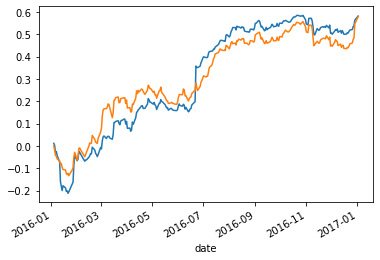

In [12]:
df_weights.dropna().groupby('date')['PnL'].sum().cumsum().plot()
df_weights.dropna().groupby('date')['target'].mean().cumsum().plot()

<hr \>

In [103]:
vol = data.pivot('date', 'asset_identifier', 'calibrated_yhat')

In [104]:
np.corrcoef(vol.values.reshape(-1), w.values.reshape(-1))

array([[1.        , 0.32806306],
       [0.32806306, 1.        ]])

In [17]:
(1.58662156e-04)**0.5 * 100

1.2596116703174831

In [23]:
port = rp.Portfolio(returns = data)

In [18]:
S = 1000 * S

In [28]:
# import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Read in price data
# df = pd.read_csv("tests/resources/stock_prices.csv", parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
# mu = expected_returns.mean_historical_return(df)
# S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

In [16]:
n = mu.shape[0]

In [17]:
w = np.random.uniform(0, 1, n)

In [18]:
mu.T @ mu

array([[6.6216694e-07]], dtype=float32)

In [19]:
%%time
x0 = w/w.sum()
w_opt = minimize(minus_sharpe, x0, (mu, S))

NameError: name 'minus_sharpe' is not defined

In [72]:
w_opt.x

array([0.03580061, 0.1270971 , 0.08721338, 0.19740564, 0.10837423,
       0.024842  , 0.13581347, 0.08185509, 0.1386146 , 0.06298389])

In [68]:
def minus_sharpe(w, *args):
    mu, S = args
    w = w/w.sum()
    mean = w.T @ mu
    variance = w.T @ S @ w
    
    return -1 * mean/variance**0.5

In [69]:
%%time
minus_sharpe(w, mu, S)

Wall time: 0 ns


array([-0.5777894])

In [37]:
mu

array([4.2347601e-04, 2.4301888e-05, 1.8509528e-04, 4.2347601e-04,
       2.4301888e-05, 2.4301888e-05, 0.0000000e+00, 4.2347601e-04,
       0.0000000e+00, 2.4301888e-05], dtype=float32)

In [3]:
df_test

,asset_identifier,ric,date,close,universe,ret,risk,yhat,target,ibov_close,ibov_ret,ibov_risk,ibov_correlation,sistematic_risk,calibrated_yhat
375314,BRABEVACNOR1,ABEV3.SA,2016-01-04,14.220944,True,-0.035854,0.016013,0.001528,0.015689,42141.0,-0.027889,0.016900,0.727769,0.011654,0.000275
375486,BRABEVACNOR1,ABEV3.SA,2016-01-05,14.444051,True,0.015689,0.015961,0.002131,-0.009725,42419.0,0.006597,0.016140,0.721313,0.011513,0.000423
375658,BRABEVACNOR1,ABEV3.SA,2016-01-06,14.303576,True,-0.009725,0.015843,0.001696,-0.026574,41773.0,-0.015229,0.016134,0.718340,0.011380,0.000275
375830,BRABEVACNOR1,ABEV3.SA,2016-01-07,13.923469,True,-0.026574,0.015936,0.001662,0.013056,40695.0,-0.025806,0.016409,0.745680,0.011883,0.000275
376002,BRABEVACNOR1,ABEV3.SA,2016-01-08,14.105259,True,0.013056,0.016030,0.002010,-0.015817,40612.0,-0.002040,0.016015,0.745834,0.011956,0.000423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624860,BRYDUQACNOR3,YDUQ3.SA,2022-02-22,22.219999,True,0.047125,0.028865,0.002128,0.014851,112892.0,0.010445,0.010764,0.530241,0.015306,0.000423
624972,BRYDUQACNOR3,YDUQ3.SA,2022-02-23,22.549999,True,0.014851,0.028917,0.000676,-0.024390,112008.0,-0.007830,0.010821,0.519775,0.015030,0.000024
625084,BRYDUQACNOR3,YDUQ3.SA,2022-02-24,22.000000,True,-0.024390,0.028579,0.000348,-0.034091,111592.0,-0.003714,0.010759,0.560299,0.016013,-0.000648
625196,BRYDUQACNOR3,YDUQ3.SA,2022-02-25,21.250000,True,-0.034091,0.028924,0.001101,-0.031059,113142.0,0.013890,0.010742,0.533595,0.015434,0.000024
